# Imbalaced data

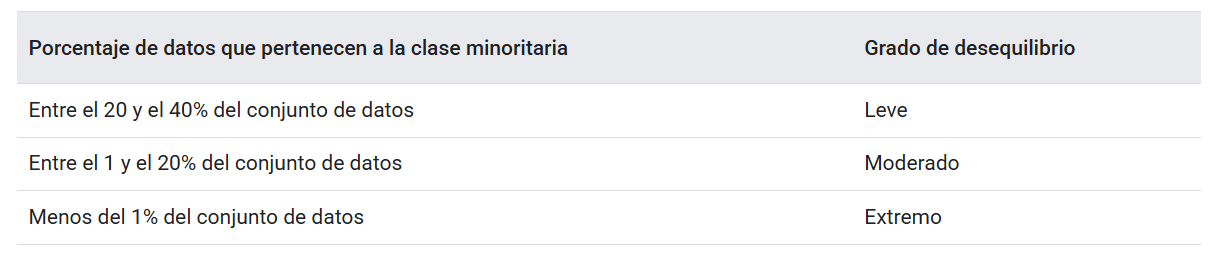

In [1]:
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 76.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


## Oversampling

### Advantages
1. **Balances class distribution**  
   Oversampling increases the number of minority class samples, helping classifiers avoid bias toward the majority class.

2. **Improves model performance on minority class**  
   By providing more data points for the minority class, models can learn better decision boundaries and reduce false negatives.

3. **Simple to implement**  
   Many oversampling techniques (like random oversampling or SMOTE) are easy to use and integrate into existing workflows.

4. **Preserves majority class data**  
   Unlike undersampling, oversampling keeps all original majority class samples, so no information is lost.

5. **Can be combined with undersampling**  
   Hybrid methods can combine oversampling and undersampling to achieve better balance and performance.

## Disadvantages
1. **Risk of overfitting**  
   Especially with random oversampling, duplicating minority class examples can cause the model to memorize instead of generalize.

2. **Increased training time and resource usage**  
   More samples mean longer training times and more computational cost.

3. **Synthetic samples may not perfectly represent real data**  
   Techniques like SMOTE generate artificial data points, which might introduce noise or unrealistic samples.

4. **Does not fix underlying data quality issues**  
   Oversampling can't improve data quality or fix mislabeled or noisy samples.

5. **Potential imbalance in feature space**  
   Synthetic samples may cluster tightly, not fully covering the diversity of the minority class.

### SMOTE (Synthetic Minority Over-sampling Technique)

Original class distribution: Counter({0: 180, 1: 20})
Resampled class distribution: Counter({0: 180, 1: 180})


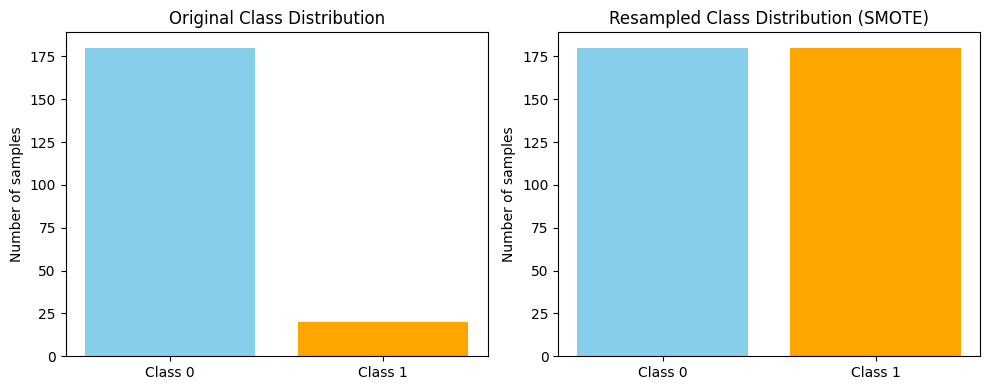

In [3]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Create synthetic imbalanced data
X, y = make_classification(n_classes=2, class_sep=2,
                           weights=[0.9, 0.1], n_informative=3,
                           n_redundant=1, flip_y=0,
                           n_features=5, n_clusters_per_class=1,
                           n_samples=200, random_state=42)

print(f"Original class distribution: {Counter(y)}")

# Plot original class distribution
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.bar(['Class 0', 'Class 1'], [sum(y==0), sum(y==1)], color=['skyblue', 'orange'])
plt.title("Original Class Distribution")
plt.ylabel("Number of samples")

# Apply oversampling with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f"Resampled class distribution: {Counter(y_resampled)}")

# Plot resampled class distribution
plt.subplot(1,2,2)
plt.bar(['Class 0', 'Class 1'], [sum(y_resampled==0), sum(y_resampled==1)], color=['skyblue', 'orange'])
plt.title("Resampled Class Distribution (SMOTE)")
plt.ylabel("Number of samples")

plt.tight_layout()
plt.show()

Original class distribution: Counter({0: 449, 1: 51})
Epoch 0 - Loss D: 1.4131, Loss G: 0.6731
Epoch 50 - Loss D: 1.4721, Loss G: 0.6931
Epoch 100 - Loss D: 1.2861, Loss G: 0.8514
Epoch 150 - Loss D: 1.3570, Loss G: 0.7130
Epoch 200 - Loss D: 1.3817, Loss G: 0.6730
Epoch 250 - Loss D: 1.3816, Loss G: 0.6953
Resampled class distribution: Counter({0.0: 449, 1.0: 141})


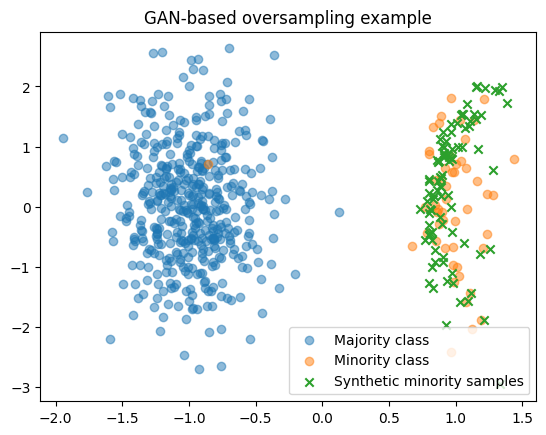

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_classification
from collections import Counter
import matplotlib.pyplot as plt

# 1. Create imbalanced dataset
X, y = make_classification(
    n_classes=2,
    n_clusters_per_class=1, 
    weights=[0.9, 0.1],
    n_samples=500,
    n_features=2,
    n_informative=1,
    n_redundant=0,
    random_state=42
)

minority_class = X[y == 1]

print(f"Original class distribution: {Counter(y)}")

# Convert minority class to tensor
minority_samples = torch.tensor(minority_class, dtype=torch.float32)

# 2. Define simple GAN architecture

class Generator(nn.Module):
    def __init__(self, noise_dim, feature_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 16),
            nn.ReLU(),
            nn.Linear(16, feature_dim)
        )
    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, feature_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(feature_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

# Hyperparameters
noise_dim = 5
feature_dim = X.shape[1]
lr = 0.001
batch_size = 16
epochs = 300

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G = Generator(noise_dim, feature_dim).to(device)
D = Discriminator(feature_dim).to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=lr)
optimizer_D = optim.Adam(D.parameters(), lr=lr)

# 3. Train GAN to generate minority samples

for epoch in range(epochs):
    for i in range(0, len(minority_samples), batch_size):
        real_data = minority_samples[i:i+batch_size].to(device)
        batch_size_curr = real_data.size(0)

        # Train Discriminator
        optimizer_D.zero_grad()
        # Real data labels = 1
        real_labels = torch.ones(batch_size_curr, 1).to(device)
        output_real = D(real_data)
        loss_real = criterion(output_real, real_labels)

        # Fake data
        noise = torch.randn(batch_size_curr, noise_dim).to(device)
        fake_data = G(noise)
        fake_labels = torch.zeros(batch_size_curr, 1).to(device)
        output_fake = D(fake_data.detach())
        loss_fake = criterion(output_fake, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        output_fake_for_G = D(fake_data)
        loss_G = criterion(output_fake_for_G, real_labels)  # want fake to be classified as real
        loss_G.backward()
        optimizer_G.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch} - Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")

# 4. Generate synthetic minority samples
num_samples_to_generate = 90  # to balance dataset
noise = torch.randn(num_samples_to_generate, noise_dim).to(device)
synthetic_samples = G(noise).cpu().detach().numpy()

# 5. Combine with original dataset
import numpy as np
X_resampled = np.vstack([X, synthetic_samples])
y_resampled = np.hstack([y, np.ones(num_samples_to_generate)])

print(f"Resampled class distribution: {Counter(y_resampled)}")

# 6. Plot original and synthetic minority samples

plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], label='Majority class', alpha=0.5)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], label='Minority class', alpha=0.5)
plt.scatter(synthetic_samples[:, 0], synthetic_samples[:, 1], label='Synthetic minority samples', marker='x')
plt.legend()
plt.title("GAN-based oversampling example")
plt.show()


### Images Data - Oversampling

Original majority class size: 6000
Original minority class size: 200
Class distribution before augmentation: Counter({0: 6000, 1: 200})


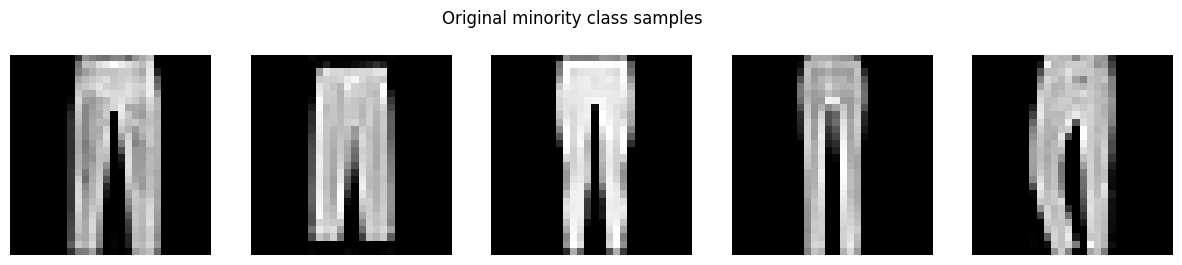

Class distribution after augmentation: Counter({0: 6000, 1: 6000})


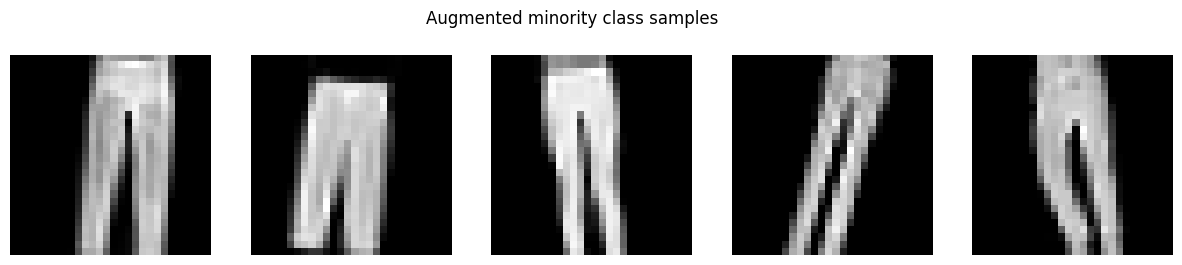

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load dataset
(X_train, y_train), (_, _) = fashion_mnist.load_data()

# Create artificially imbalanced dataset for demo

# Majority class: class 0 (T-shirt/top)
X_majority = X_train[y_train == 0]
y_majority = y_train[y_train == 0]

# Minority class: class 1 (Trouser), limit to 200 samples
X_minority = X_train[y_train == 1][:200]
y_minority = y_train[y_train == 1][:200]

print(f"Original majority class size: {len(y_majority)}")
print(f"Original minority class size: {len(y_minority)}")

# Combine data
X = np.concatenate([X_majority, X_minority], axis=0)
y = np.concatenate([y_majority, y_minority], axis=0)

print("Class distribution before augmentation:", Counter(y))

# Reshape images for ImageDataGenerator
X = X.reshape((-1, 28, 28, 1))

# Show some original minority class samples before augmentation
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].imshow(X_minority[i], cmap='gray')
    axes[i].axis('off')
plt.suptitle("Original minority class samples")
plt.show()

# Data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Calculate how many new images we need to balance
num_to_generate = len(y_majority) - len(y_minority)

# Generate augmented images for minority class
augmented_images = []
augmented_labels = []

minority_images = X[y == 1]

aug_iter = datagen.flow(minority_images, batch_size=1, shuffle=False)

for _ in range(num_to_generate):
    img_aug = next(aug_iter)[0]
    augmented_images.append(img_aug)
    augmented_labels.append(1)

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Combine original data with augmented minority class
X_balanced = np.concatenate([X, augmented_images], axis=0)
y_balanced = np.concatenate([y, augmented_labels], axis=0)

print("Class distribution after augmentation:", Counter(y_balanced))

# Show some augmented minority class samples
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].imshow(augmented_images[i].reshape(28, 28), cmap='gray')
    axes[i].axis('off')
plt.suptitle("Augmented minority class samples")
plt.show()


Original class distribution: Counter({0: 10, 1: 2})
Number of samples to generate to balance classes: 8
Pitch shifted by 2 semitones
Pitch shifted by -2 semitones
Pitch shifted by -1 semitones
Speed changed by factor 0.90
Speed changed by factor 1.12
Speed changed by factor 0.96
Pitch shifted by -2 semitones
Speed changed by factor 0.84
Balanced class distribution: Counter({0: 10, 1: 10})


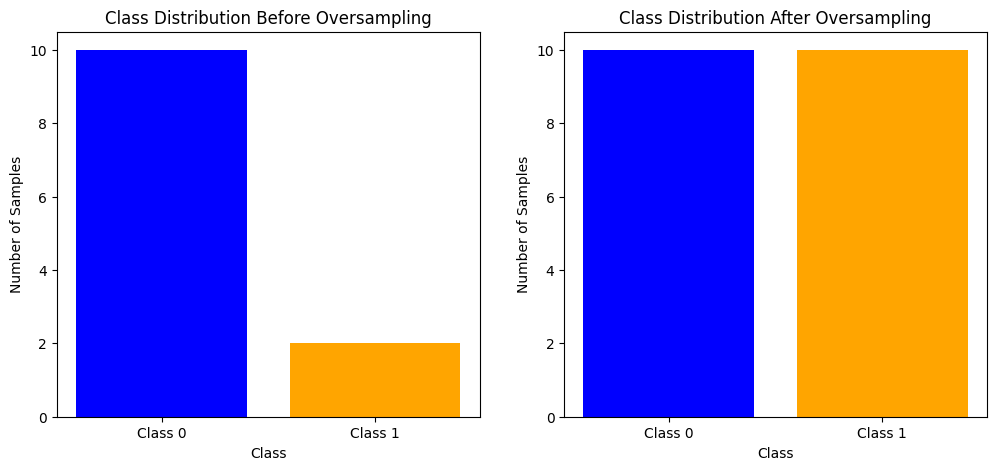

Playing one original minority class sample:


Playing one augmented minority class sample:


In [16]:
import librosa
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import Audio, display

# load data
base_audio, sr = librosa.load(librosa.ex('trumpet'), sr=22050)

# Create majority class (class 0) with 10 copies of the base audio
X_majority = [base_audio] * 10
y_majority = [0] * 10

# Create minority class (class 1) with 2 copies of the base audio
X_minority = [base_audio] * 2
y_minority = [1] * 2

print(f"Original class distribution: {Counter(y_majority + y_minority)}")

# define

def change_pitch(data, sr=22050, n_steps=2):
    return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=n_steps)

def change_speed(data, speed_factor=1.2):
    return librosa.effects.time_stretch(y=data, rate=speed_factor)

def augment_audio(sample, sr=22050):
    aug_choice = random.choice(['pitch', 'speed'])
    if aug_choice == 'pitch':
        steps = random.choice([-2, -1, 1, 2])
        augmented = change_pitch(sample, sr=sr, n_steps=steps)
        print(f"Pitch shifted by {steps} semitones")
    else:
        speed = random.uniform(0.8, 1.2)
        augmented = change_speed(sample, speed_factor=speed)
        print(f"Speed changed by factor {speed:.2f}")
    return augmented

# oversampling

num_to_generate = len(y_majority) - len(y_minority)
print(f"Number of samples to generate to balance classes: {num_to_generate}")

augmented_samples = []
augmented_labels = []

for _ in range(num_to_generate):
    sample_to_augment = random.choice(X_minority)
    augmented_audio = augment_audio(sample_to_augment, sr)
    augmented_samples.append(augmented_audio)
    augmented_labels.append(1)

# combine data

X_balanced = X_majority + X_minority + augmented_samples
y_balanced = y_majority + y_minority + augmented_labels

print(f"Balanced class distribution: {Counter(y_balanced)}")

# plot

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Before oversampling
counts_before = Counter(y_majority + y_minority)
axs[0].bar(counts_before.keys(), counts_before.values(), color=['blue', 'orange'])
axs[0].set_title("Class Distribution Before Oversampling")
axs[0].set_xlabel("Class")
axs[0].set_ylabel("Number of Samples")
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(['Class 0', 'Class 1'])

# After oversampling
counts_after = Counter(y_balanced)
axs[1].bar(counts_after.keys(), counts_after.values(), color=['blue', 'orange'])
axs[1].set_title("Class Distribution After Oversampling")
axs[1].set_xlabel("Class")
axs[1].set_ylabel("Number of Samples")
axs[1].set_xticks([0, 1])
axs[1].set_xticklabels(['Class 0', 'Class 1'])

plt.show()


# --- Step 6: Play original and augmented audio samples ---

print("Playing one original minority class sample:")
display(Audio(X_minority[0], rate=sr))

print("Playing one augmented minority class sample:")
display(Audio(augmented_samples[0], rate=sr))

## Undersampling: 

### Advantages
- **Balances Dataset Quickly:** Reduces the size of the majority class to match the minority class, which balances the dataset efficiently.
- **Speeds Up Training:** Smaller datasets mean faster training times and lower computational costs.
- **Simplifies Models:** By reducing data, it can help prevent overfitting on the majority class.
- **Easy to Implement:** Straightforward to apply, often just random removal of majority class samples.

### Disadvantages
- **Loss of Information:** Removes potentially useful data from the majority class, which can degrade model performance.
- **Risk of Underfitting:** By reducing training data, the model may not learn enough about the majority class patterns.
- **Not Suitable for Small Datasets:** If the dataset is already small, undersampling can lead to too little training data.
- **Randomness Issues:** Random undersampling may remove important examples, causing instability in results.


Original class distribution: Counter({0: 450, 1: 50})
Resampled class distribution: Counter({0: 50, 1: 50})


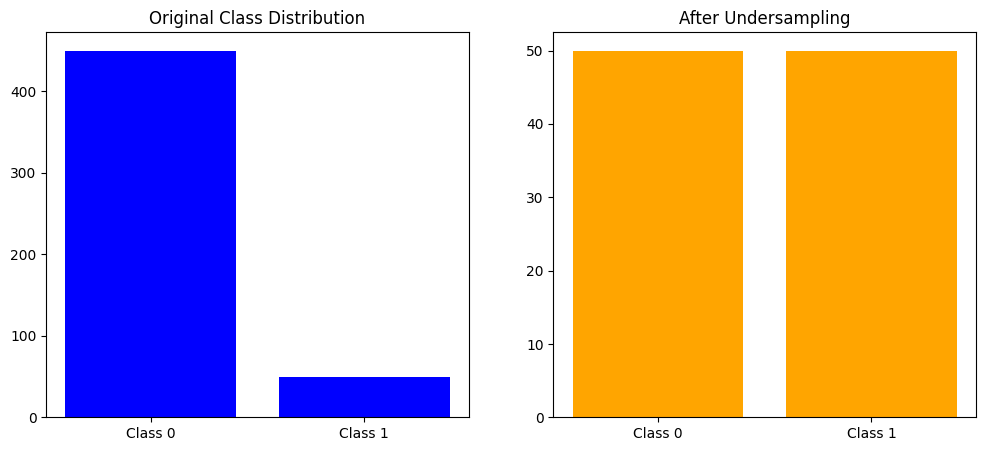

In [17]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt

# 1. Create imbalanced dataset
X, y = make_classification(n_classes=2, class_sep=2,
                           weights=[0.9, 0.1], n_informative=3,
                           n_redundant=1, flip_y=0,
                           n_features=5, n_clusters_per_class=1,
                           n_samples=500, random_state=42)

print(f"Original class distribution: {Counter(y)}")

# 2. Apply random undersampling
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

print(f"Resampled class distribution: {Counter(y_resampled)}")

# 3. Plot before and after undersampling
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(['Class 0', 'Class 1'], [sum(y == 0), sum(y == 1)], color='blue')
axes[0].set_title('Original Class Distribution')

axes[1].bar(['Class 0', 'Class 1'], [sum(y_resampled == 0), sum(y_resampled == 1)], color='orange')
axes[1].set_title('After Undersampling')

plt.show()

## Advantages and Disadvantages of Using Class Weights

### Advantages

- **Improves Minority Class Performance:**  
  Assigning higher weights to minority classes helps the model pay more attention to them, improving recall and precision for these classes.

- **No Data Duplication Needed:**  
  Unlike oversampling, class weights don’t increase the dataset size, avoiding longer training times and potential overfitting.

- **Simple to Implement:**  
  Most machine learning libraries (e.g., scikit-learn, XGBoost) support class weights natively with minimal code changes.

- **Balances Learning Objective:**  
  The loss function is adjusted dynamically, which often leads to better generalization on imbalanced datasets.

### Disadvantages

- **May Lead to Overfitting Minority Class:**  
  Over-weighting minority classes might cause the model to overfit on limited samples, reducing generalization.

- **Not Always Effective for Severe Imbalance:**  
  When the class imbalance is extreme, class weighting alone might not be sufficient to balance the model’s performance.

- **Can Impact Majority Class Performance:**  
  Increasing focus on minority classes can sometimes reduce accuracy on the majority class.

- **Needs Careful Tuning:**  
  Improper weighting (e.g., weights too high or low) can destabilize training or hurt overall performance.

- **Algorithm Dependent:**  
  Some algorithms or models might not support class weights well or interpret them differently, leading to inconsistent results.


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc

import warnings
warnings.filterwarnings('ignore') # Suppress warnings

print("Libraries loaded successfully!")

# --- 1. Generate an Imbalanced Dataset ---
X, y = make_classification(
    n_samples=1000,          # Total number of samples
    n_features=2,            # Number of features
    n_informative=2,         # Number of informative features
    n_redundant=0,           # Number of redundant features
    n_repeated=0,            # Number of repeated features
    n_classes=2,             # Number of target classes
    n_clusters_per_class=1,  # Number of clusters per class
    weights=[0.95, 0.05],    # Class distribution (95% for class 0, 5% for class 1)
    flip_y=0,                # No noise
    random_state=42          # For reproducibility
)

X = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
y = pd.Series(y)

print(f"Original dataset shape: {Counter(y)}")
print(f"Majority class (0): {Counter(y)[0]} samples")
print(f"Minority class (1): {Counter(y)[1]} samples")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print(f"\nTraining set shape: {Counter(y_train)}")
print(f"Test set shape: {Counter(y_test)}")

# --- 2. Baseline Random Forest (Without class_weight) ---
print("\n--- Baseline Random Forest Classifier (no class_weight) ---")
model_baseline_rf = RandomForestClassifier(random_state=42, n_estimators=100)
model_baseline_rf.fit(X_train, y_train)
y_pred_baseline_rf = model_baseline_rf.predict(X_test)
y_prob_baseline_rf = model_baseline_rf.predict_proba(X_test)[:, 1]

report_baseline = classification_report(y_test, y_pred_baseline_rf, output_dict=True)
print("\nClassification Report (Baseline RF):\n", classification_report(y_test, y_pred_baseline_rf))
print("ROC AUC Score (Baseline RF):", roc_auc_score(y_test, y_prob_baseline_rf))
precision_bl_rf, recall_bl_rf, _ = precision_recall_curve(y_test, y_prob_baseline_rf)
auc_pr_bl_rf = auc(recall_bl_rf, precision_bl_rf)
print("AUC-PR Score (Baseline RF):", auc_pr_bl_rf)


# --- 3. Cost-Sensitive Random Forest (with class_weight='balanced') ---
print("\n--- Cost-Sensitive Random Forest Classifier (class_weight='balanced') ---")
model_balanced_rf = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
model_balanced_rf.fit(X_train, y_train)
y_pred_balanced_rf = model_balanced_rf.predict(X_test)
y_prob_balanced_rf = model_balanced_rf.predict_proba(X_test)[:, 1]

report_balanced = classification_report(y_test, y_pred_balanced_rf, output_dict=True)
print("\nClassification Report (Balanced RF):\n", classification_report(y_test, y_pred_balanced_rf))
print("ROC AUC Score (Balanced RF):", roc_auc_score(y_test, y_prob_balanced_rf))
precision_bal_rf, recall_bal_rf, _ = precision_recall_curve(y_test, y_prob_balanced_rf)
auc_pr_bal_rf = auc(recall_bal_rf, precision_bal_rf)
print("AUC-PR Score (Balanced RF):", auc_pr_bal_rf)


# --- 4. Prepare data for Bar Charts ---
metrics = ['precision', 'recall', 'f1-score']
classes = ['0', '1']

# Data for Baseline RF
baseline_data = {
    'Metric': [],
    'Class': [],
    'Value': [],
    'Model': []
}
for cls in classes:
    for metric in metrics:
        baseline_data['Metric'].append(metric)
        baseline_data['Class'].append(f'Class {cls}')
        baseline_data['Value'].append(report_baseline[cls][metric])
        baseline_data['Model'].append('Baseline RF')

# Data for Balanced RF
balanced_data = {
    'Metric': [],
    'Class': [],
    'Value': [],
    'Model': []
}
for cls in classes:
    for metric in metrics:
        balanced_data['Metric'].append(metric)
        balanced_data['Class'].append(f'Class {cls}')
        balanced_data['Value'].append(report_balanced[cls][metric])
        balanced_data['Model'].append('Balanced RF')

df_baseline = pd.DataFrame(baseline_data)
df_balanced = pd.DataFrame(balanced_data)

# Combine for easier plotting
df_comparison = pd.concat([df_baseline, df_balanced])


print("\n--- Interpretation of Bar Charts ---")
print("You should observe a trade-off:")
print("- **For Class 0 (Majority):** Precision, Recall, and F1-score might slightly decrease or stay similar for the Balanced RF compared to Baseline RF.")
print("- **For Class 1 (Minority):** Precision might slightly decrease, but **Recall and F1-score should significantly increase** for the Balanced RF.")
print("This indicates that the cost-sensitive model is better at identifying the minority class, which is the primary goal when dealing with imbalanced data.")

Libraries loaded successfully!
Original dataset shape: Counter({0: 950, 1: 50})
Majority class (0): 950 samples
Minority class (1): 50 samples

Training set shape: Counter({0: 665, 1: 35})
Test set shape: Counter({0: 285, 1: 15})

--- Baseline Random Forest Classifier (no class_weight) ---

Classification Report (Baseline RF):
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       285
           1       1.00      0.87      0.93        15

    accuracy                           0.99       300
   macro avg       1.00      0.93      0.96       300
weighted avg       0.99      0.99      0.99       300

ROC AUC Score (Baseline RF): 0.9619883040935673
AUC-PR Score (Baseline RF): 0.9357222222222222

--- Cost-Sensitive Random Forest Classifier (class_weight='balanced') ---

Classification Report (Balanced RF):
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       285
           1       1.00  

## Ensemble Methods: Advantages and Disadvantages

### Advantages

- **Improved Performance:**  
  By combining multiple models, ensembles often achieve better accuracy and robustness than individual models.

- **Better Handling of Imbalance:**  
  Methods like Balanced Random Forest and EasyEnsemble specifically focus on addressing class imbalance by undersampling or resampling within ensemble members.

- **Reduced Overfitting:**  
  Aggregating predictions helps smooth out noise and overfitting that single models might suffer.

- **Flexibility:**  
  You can mix different base learners or sampling techniques to tailor the ensemble to your problem.

- **Works Well with Complex Data:**  
  Can capture complex patterns in the data that simple models might miss.

---

### Disadvantages

- **Increased Complexity:**  
  Ensembles are harder to interpret and explain compared to single models.

- **Computationally Expensive:**  
  Training multiple models requires more time and resources.

- **Harder to Tune:**  
  More hyperparameters and components make optimization more challenging.

- **Diminishing Returns:**  
  Adding too many models can lead to minimal improvements while increasing complexity.

- **Risk of Bias If Data Sampling Is Poor:**  
  If the resampling within ensemble members isn't well designed, the imbalance problem might persist.


Libraries loaded successfully!
Original dataset shape: Counter({0: 950, 1: 50})
Majority class (0): 950 samples
Minority class (1): 50 samples

Training set shape: Counter({0: 665, 1: 35})
Test set shape: Counter({0: 285, 1: 15})

--- Baseline Random Forest Classifier (no class_weight) ---

Classification Report (Baseline RF):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       285
           1       1.00      0.87      0.93        15

    accuracy                           0.99       300
   macro avg       1.00      0.93      0.96       300
weighted avg       0.99      0.99      0.99       300

ROC AUC Score (Baseline RF): 0.9619883040935673
AUC-PR Score (Baseline RF): 0.9357222222222222

--- BalancedBaggingClassifier ---

Classification Report (BalancedBaggingClassifier):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       285
           1       1.00      0.93      0.97        15

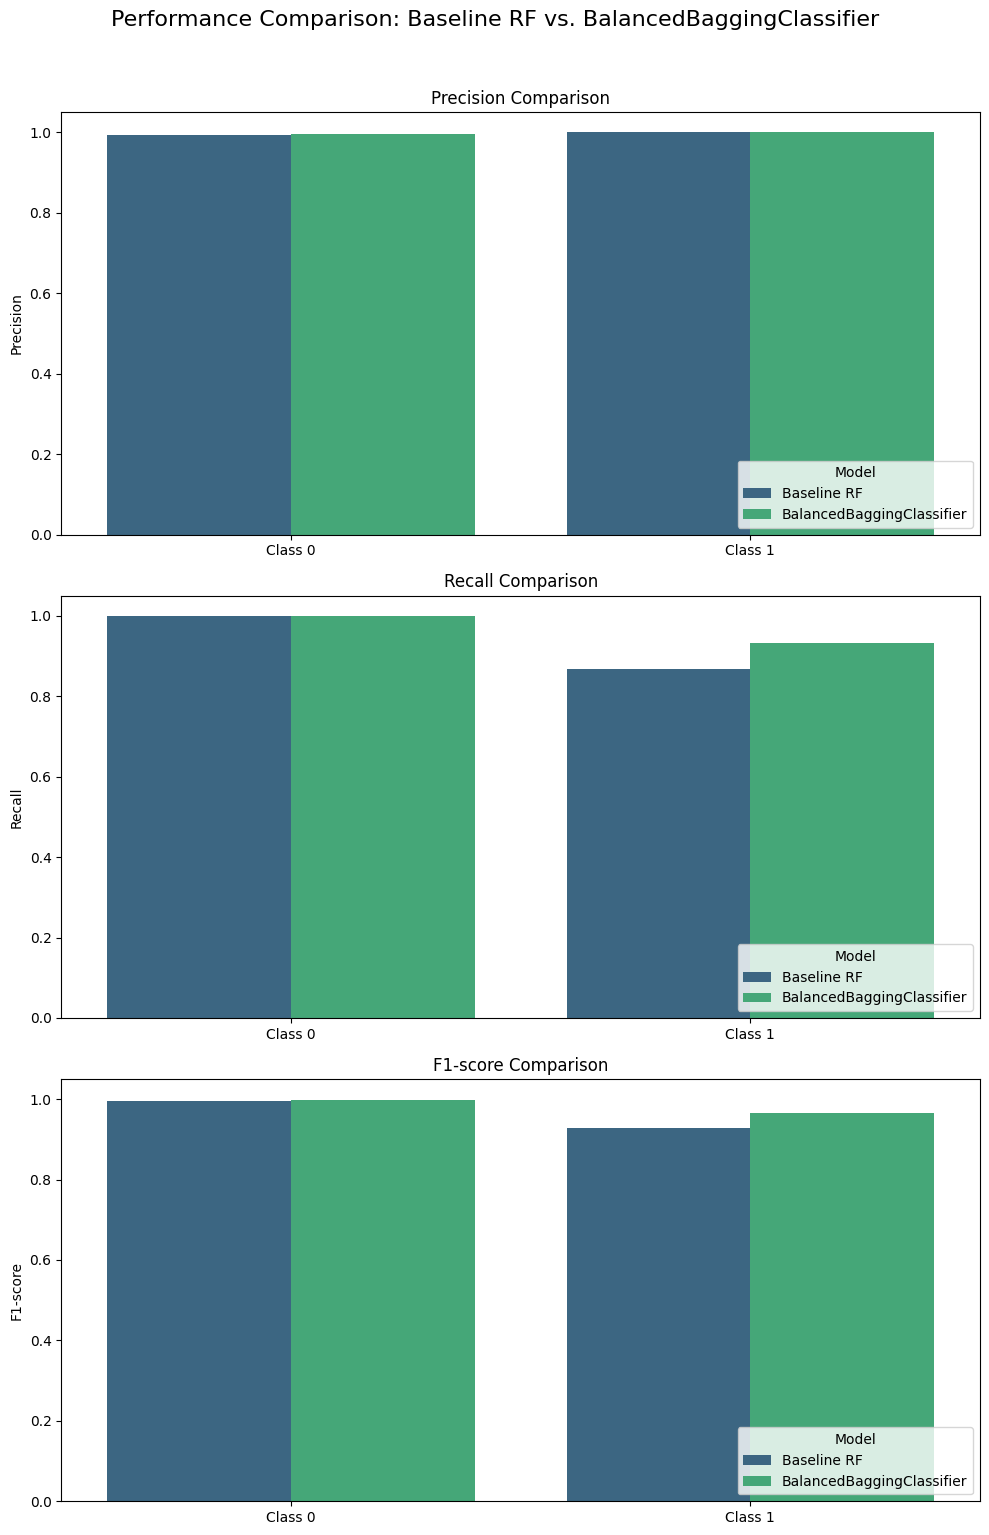


--- Interpretation of Bar Charts ---
You should observe that `BalancedBaggingClassifier` significantly improves metrics for the minority class (Class 1) compared to the Baseline Random Forest.
- **For Class 0 (Majority):** Performance might be similar or slightly lower for BalancedBaggingClassifier.
- **For Class 1 (Minority):** You should see a noticeable **increase in Recall and F1-score**. Precision might vary, but the overall balance in performance between classes should be much better.
This demonstrates how `BalancedBaggingClassifier` effectively addresses the class imbalance problem by ensuring that each base estimator is trained on a more balanced subset of the data.


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier # Often a good base estimator for Bagging
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc

# Import BalancedBaggingClassifier from imbalanced-learn
from imblearn.ensemble import BalancedBaggingClassifier

import warnings
warnings.filterwarnings('ignore') # Suppress warnings

print("Libraries loaded successfully!")

# --- 1. Generate an Imbalanced Dataset ---
X, y = make_classification(
    n_samples=1000,          # Total number of samples
    n_features=2,            # Number of features
    n_informative=2,         # Number of informative features
    n_redundant=0,           # Number of redundant features
    n_repeated=0,            # Number of repeated features
    n_classes=2,             # Number of target classes
    n_clusters_per_class=1,  # Number of clusters per class
    weights=[0.95, 0.05],    # Class distribution (95% for class 0, 5% for class 1)
    flip_y=0,                # No noise
    random_state=42          # For reproducibility
)

X = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
y = pd.Series(y)

print(f"Original dataset shape: {Counter(y)}")
print(f"Majority class (0): {Counter(y)[0]} samples")
print(f"Minority class (1): {Counter(y)[1]} samples")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print(f"\nTraining set shape: {Counter(y_train)}")
print(f"Test set shape: {Counter(y_test)}")

# --- 2. Baseline Random Forest Classifier (for comparison) ---
print("\n--- Baseline Random Forest Classifier (no class_weight) ---")
model_baseline_rf = RandomForestClassifier(random_state=42, n_estimators=100)
model_baseline_rf.fit(X_train, y_train)
y_pred_baseline_rf = model_baseline_rf.predict(X_test)
y_prob_baseline_rf = model_baseline_rf.predict_proba(X_test)[:, 1]

report_baseline = classification_report(y_test, y_pred_baseline_rf, output_dict=True)
print(f"\nClassification Report (Baseline RF):\n{classification_report(y_test, y_pred_baseline_rf)}")
print("ROC AUC Score (Baseline RF):", roc_auc_score(y_test, y_prob_baseline_rf))
precision_bl_rf, recall_bl_rf, _ = precision_recall_curve(y_test, y_prob_baseline_rf)
auc_pr_bl_rf = auc(recall_bl_rf, precision_bl_rf)
print("AUC-PR Score (Baseline RF):", auc_pr_bl_rf)


# --- 3. BalancedBaggingClassifier ---
print("\n--- BalancedBaggingClassifier ---")
# Using a DecisionTreeClassifier as the base estimator is common for Bagging
# sampling_strategy='auto' will undersample the majority class to balance each bag
bbc_model = BalancedBaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=100,  # Number of base estimators
    sampling_strategy='auto', # 'auto' will undersample majority class to match minority
    replacement=False, # Draw samples without replacement for undersampling
    random_state=42,
    n_jobs=-1 # Use all available CPU cores for parallel processing
)
bbc_model.fit(X_train, y_train)
y_pred_bbc = bbc_model.predict(X_test)
y_prob_bbc = bbc_model.predict_proba(X_test)[:, 1]

report_bbc = classification_report(y_test, y_pred_bbc, output_dict=True)
print(f"\nClassification Report (BalancedBaggingClassifier):\n{classification_report(y_test, y_pred_bbc)}")
print("ROC AUC Score (BalancedBaggingClassifier):", roc_auc_score(y_test, y_prob_bbc))
precision_bbc, recall_bbc, _ = precision_recall_curve(y_test, y_prob_bbc)
auc_pr_bbc = auc(recall_bbc, precision_bbc)
print("AUC-PR Score (BalancedBaggingClassifier):", auc_pr_bbc)


# --- 4. Prepare data for Bar Charts ---
metrics = ['precision', 'recall', 'f1-score']
classes = ['0', '1']

# Data for Baseline RF
baseline_data = {
    'Metric': [],
    'Class': [],
    'Value': [],
    'Model': []
}
for cls in classes:
    for metric in metrics:
        baseline_data['Metric'].append(metric)
        baseline_data['Class'].append(f'Class {cls}')
        if cls in report_baseline and metric in report_baseline[cls]:
            baseline_data['Value'].append(report_baseline[cls][metric])
        else: # Handle cases where a class might have 0 precision/recall (not present in report)
            baseline_data['Value'].append(0.0)
        baseline_data['Model'].append('Baseline RF')

# Data for BalancedBaggingClassifier
bbc_data = {
    'Metric': [],
    'Class': [],
    'Value': [],
    'Model': []
}
for cls in classes:
    for metric in metrics:
        bbc_data['Metric'].append(metric)
        bbc_data['Class'].append(f'Class {cls}')
        if cls in report_bbc and metric in report_bbc[cls]:
            bbc_data['Value'].append(report_bbc[cls][metric])
        else: # Handle cases where a class might have 0 precision/recall
            bbc_data['Value'].append(0.0)
        bbc_data['Model'].append('BalancedBaggingClassifier')

df_baseline = pd.DataFrame(baseline_data)
df_bbc = pd.DataFrame(bbc_data)

# Combine for easier plotting
df_comparison = pd.concat([df_baseline, df_bbc])


# --- 5. Create Bar Charts for Comparison ---

fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 15), sharey=True)
fig.suptitle('Performance Comparison: Baseline RF vs. BalancedBaggingClassifier', fontsize=16, y=1.02)

for i, metric in enumerate(metrics):
    ax = axes[i]
    metric_df = df_comparison[df_comparison['Metric'] == metric]
    sns.barplot(x='Class', y='Value', hue='Model', data=metric_df, ax=ax, palette='viridis')
    ax.set_title(f'{metric.capitalize()} Comparison')
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel('')
    ax.set_ylim(0, 1.05) # Metrics are between 0 and 1
    ax.legend(title='Model', loc='lower right')

plt.tight_layout()
plt.show()

print("\n--- Interpretation of Bar Charts ---")
print("You should observe that `BalancedBaggingClassifier` significantly improves metrics for the minority class (Class 1) compared to the Baseline Random Forest.")
print("- **For Class 0 (Majority):** Performance might be similar or slightly lower for BalancedBaggingClassifier.")
print("- **For Class 1 (Minority):** You should see a noticeable **increase in Recall and F1-score**. Precision might vary, but the overall balance in performance between classes should be much better.")
print("This demonstrates how `BalancedBaggingClassifier` effectively addresses the class imbalance problem by ensuring that each base estimator is trained on a more balanced subset of the data.")

# Metrics and Loss Functions for Imbalanced Data

## Metrics

- **Precision**  
  Measures the proportion of true positives among all positive predictions. Useful when false positives are costly.

- **Recall (Sensitivity, True Positive Rate)**  
  Measures the proportion of true positives detected among all actual positives. Important when missing positive cases is costly.

- **F1 Score**  
  Harmonic mean of precision and recall, balances both metrics. Great overall metric for imbalanced problems.

- **Area Under the ROC Curve (AUC-ROC)**  
  Measures the ability to distinguish between classes at various threshold settings.

- **Area Under the Precision-Recall Curve (AUC-PR)**  
  More informative than AUC-ROC when dealing with high class imbalance.

- **Balanced Accuracy**  
  Average of recall obtained on each class. Corrects accuracy bias in imbalanced datasets.

- **Matthews Correlation Coefficient (MCC)**  
  A balanced metric that takes into account true and false positives and negatives.

---

## Loss Functions

- **Weighted Cross-Entropy Loss**  
  Applies higher penalty to misclassification of minority class by weighting classes differently.

- **Focal Loss**  
  Focuses training on hard examples by reducing the loss contribution from easy examples. Useful for extreme imbalance.

- **Dice Loss / Jaccard Loss**  
  Often used in segmentation tasks, emphasizing overlap between predicted and true classes.

- **Tversky Loss**  
  A generalization of Dice loss with adjustable parameters to balance false positives and false negatives.

- **Balanced or Class-Weighted Hinge Loss**  
  Used in SVMs to give different importance to classes.

---

**Summary:**  
Choosing the right metric and loss depends on the task and cost of different errors. Often, combining class-weighted losses with metrics like F1-score or AUC-PR provides a robust approach to imbalanced classification.


# References
- https://developers.google.com/machine-learning/crash-course/overfitting/imbalanced-datasets?hl=es-419